<a href="https://colab.research.google.com/github/jjmatthiesen/homeOffice/blob/main/HOMPA-example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Home Office Calculation

The COVID pandemic has made working from home necessary, and many employees want to continue doing so even after the pandemic. There are advantages and drawbacks to the home office trend from both employer and employee perspectives. Determining the ideal proportion of home office for each employee is important but there is a research gap in how to do so. This work presents an algorithm that considers multiple perspectives to determine the ideal proportion of home office, including the employer's view, demographic and social factors of the employee, and the employee's preferred proportion of home office. The algorithm combines findings from several studies and can identify discrepancies between these perspectives.

In [ ]:
# dtale requires statsmodels to be updated; see https://stackoverflow.com/questions/71106940/cannot-import-name-centered-from-scipy-signal-signaltools

!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dtale
!pip install pygwalker
!pip install seaborn[stats]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.7/642.7 KB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.7/219.7 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 KB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Just for checking the required package versions

#!pip list

In [ ]:
import pygwalker as pyg
import pandas as pd

import dtale
import dtale.app as dtale_app

from IPython.display import Image
import numpy as np
import datetime
import warnings
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import pyplot as plt
#import seaborn.objects as so

In [ ]:
def load_data(comp):
    d_employees = pd.read_csv('./data/' + comp + '/employees_' + comp + '.csv', sep=',')
    d_tasks = pd.read_csv('./data/' + comp + '/tasks_' + comp + '.csv', sep=',')
    d_employee_input = pd.read_csv('./data/' + comp + '/employee_input_' + comp + '.csv', sep=',')
    return d_employees, d_tasks, d_employee_input

# calculate diff between today and the start date at the company
def tenure(start_date):
    date_now = datetime.datetime.utcnow()
    date_diff = int((date_now - start_date).days)
    return date_diff

# probationary period
def ho_prob(days):
    if days < 180:
        home_office_prob = 0
    else:
        home_office_prob = 100
    return home_office_prob


# calculate the home office proportion based on the age (gen-preference)
def ho_generation(year):
    if 1946 <= year <= 1964:
        return 48
    elif 1965 <= year <= 1980:
        return 50
    elif 1981 <= year <= 1994:
        return 44
    else:
        return 28


# calculate the home office proportion based on the education
def ho_degree(degree):
    if degree == 'Hochschule':
        return 48
    elif degree == 'mittlere Reife':
        return 17
    else:
        return 8


# calculate the home office proportion based on the commute time
def ho_commute(time):
    if time > 40:
        return 46
    elif 20 <= time <= 40:
        return 2.3 * time -46 # linear decline
    else:
        return 0


# calculate the home office proportion based on caring responsibility
def ho_gender_resp(employees):
    if employees['Caring Responsibility'] and employees['Gender'] == 'female':
        return 56.1
    elif employees['Caring Responsibility'] and employees['Gender'] == 'male':
        return 52
    else:
        return 50


# calculate the preferred proportion of home office
def ho_prefer(employee_input):
    if employee_input['ho_wish'] == True:
        return (employee_input['desired_days'] / 5) * 100
    else:
        return 0

# calculate derivations
def deviation(ho_shares):
    ho_shares['difference_to_max'] = int(ho_shares['ho_max'] - ho_shares['ho_prefer'])
    ho_shares['difference_to_opt'] = int(ho_shares['ho_opt'] - ho_shares['ho_prefer'])
    ho_shares['difference_to_social'] = int(ho_shares['ho_social'] - ho_shares['ho_prefer'])
    return ho_shares

# see Kawakubo, S., & Arata, S. (2022). Study on residential environment and workers’ personality traits on productivity while working from home. Building and Environment, 212, 108787. 

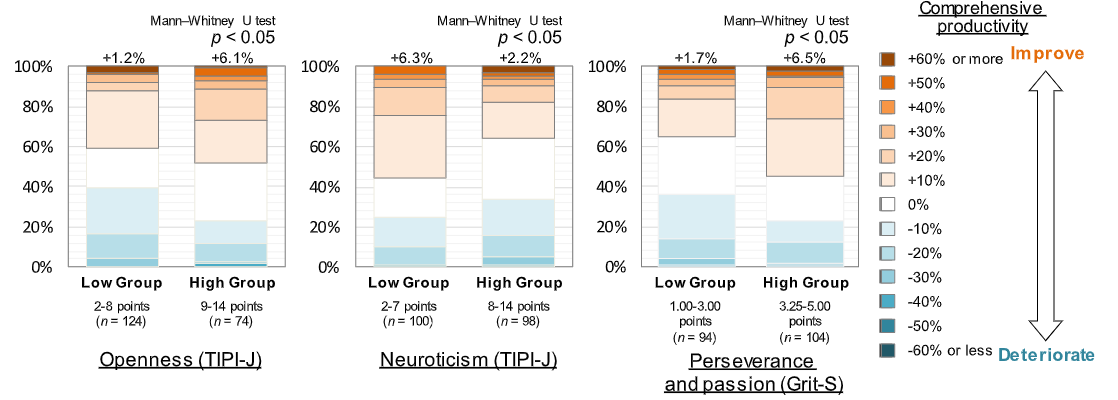

In [ ]:
# calculate the preferred proportion of home office based on personality traits
# see Kawakubo, S., & Arata, S. (2022). Study on residential environment and workers’ personality traits on productivity while working from home. Building and Environment, 212, 108787. 
def ho_personality_openness(employee_input):
    if 2 <= employee_input['openness'] <= 8:
        return 1.2
    else:
        return 6.1

def ho_personality_neuroticism(employee_input):
    if 2 <= employee_input['neuroticism'] <= 7:
        return 6.3
    else:
        return 2.2

def ho_personality_perseverance_and_passion(employee_input):
    if 1 <= employee_input['perseverance_and_grit'] <= 3:
        return 1.7
    else:
        return 6.5

# the other three factorsare not significant, therefore, we currently avoid these
#Conscientiousness 
#Extraversion 
##Agreeableness 


# we calculate the percentage based on the single value
def ho_personality__complete(employee_input):
  return ((ho_personality_openness(employee_input) + ho_personality_neuroticism(employee_input) + ho_personality_perseverance_and_passion(employee_input))/(6.1+6.3+6.5)) * 100

# Visualize Different Functions using NumPy (not complete)

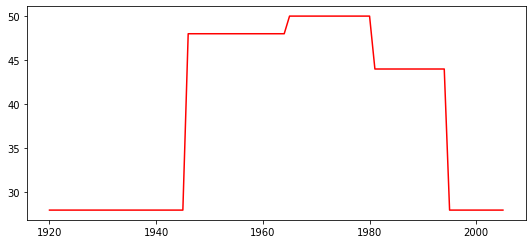

In [ ]:
### visualize different functions


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True


# Use np for arrays; see https://stackoverflow.com/a/47195696 

def ho_generation_conditions(year):
    if   1946 <= year <= 1964:   return 48
    elif 1965 <= year <= 1980:   return 50
    elif 1981 <= year <= 1994:    return 44
    else:           return 28
ho_generation_np = np.vectorize(ho_generation_conditions)

x = np.linspace(1920, 2005, 100, dtype='int')
plt.plot(x, ho_generation_np(x), color='red')


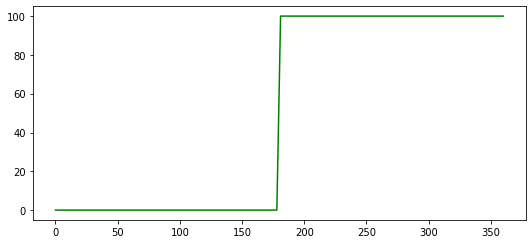

In [ ]:
def ho_prob_conditions(days):
    if   days < 180:   return 0
    else:              return 100
ho_prob_np = np.vectorize(ho_prob_conditions)



# one year
x = np.linspace(0, 360, 100, dtype='int')
plt.plot(x, ho_prob_np(x), color='g')


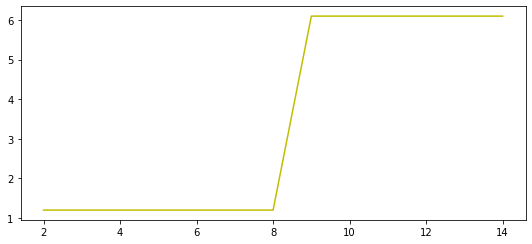

In [ ]:
def ho_personality_openness_conditions(openness):
    if   2 <= openness <= 8:   return 1.2
    else:           return 6.1
ho_personality_openness_np = np.vectorize(ho_personality_openness_conditions)



x = np.linspace(2, 14, 20, dtype='int')
plt.plot(x, ho_personality_openness_np(x), color='y')



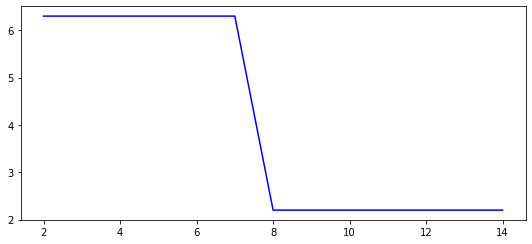

In [ ]:
def ho_personality_neuroticism_conditions(neuroticism):
    if   2 <= neuroticism <= 7:   return 6.3
    else:           return 2.2
ho_personality_neuroticism_np = np.vectorize(ho_personality_neuroticism_conditions)



x = np.linspace(2, 14, 20, dtype='int')
plt.plot(x, ho_personality_neuroticism_np(x), color='b')


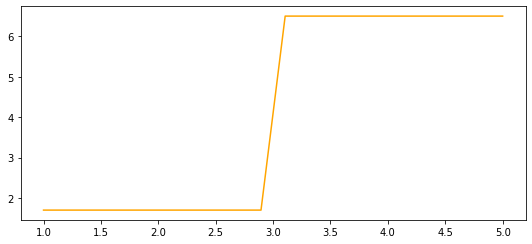

In [ ]:
def ho_personality_perseverance_and_passion_conditions(perseverance_and_grit):
    if   1 <= perseverance_and_grit <= 3:   return 1.7
    else:           return 6.5
ho_personality_perseverance_and_passion_np = np.vectorize(ho_personality_perseverance_and_passion_conditions)



x = np.linspace(1, 5, 20, dtype='float')
plt.plot(x, ho_personality_perseverance_and_passion_np(x), color='orange')


In [ ]:
# this will work once we have the data public
#employees, tasks, employee_input = load_data('example)

In [ ]:
employees = pd.DataFrame([['111111', 'AA', '1962-02-23', '2000-07-01', 'male', 'Hochschule', 'HR Manager'], ['111112', 'BB', '1996-09-16', '2021-02-01', 'female', 'mittlere Reife', 'Purchasing Manager'], ['111113', 'CC', '1988-04-12', '2018-10-01', 'female', 'Hochschule', 'Secretary'], ['111114', 'DD', '1973-12-31', '1995-01-01', 'female', 'Hauptschulabschluss', 'Janitor'], ['111115', 'EE', '1986-07-03', '2010-12-01', 'male', 'Hauptschulabschluss', 'Cleaning staff'], ['111116', 'FF', '1965-04-19', '2003-04-01', 'male', 'Hochschule', 'IT specialist 1'], ['111117', 'GG', '1977-09-23', '2008-05-01', 'male', 'Hochschule', 'Controller'], ['111118', 'HH', '1971-10-26', '2014-06-01', 'female', 'Hochschule', 'IT specialist 2'], ['111119', 'II', '1994-11-02', '2020-08-01', 'female', 'Hochschule', 'Marketing Manager'], ['111120', 'JJ', '1958-05-16', '1996-11-01', 'female', 'Hochschule', 'Team Leader - Finance'], ['111121', 'KK', '1981-04-23', '2021-06-01', 'male', 'mittlere Reife', 'Sales representative'], ['111122', 'LL', '1970-09-21', '2010-06-01', 'female', 'mittlere Reife', 'Store manager'], ['111123', 'MM', '1988-12-22', '2020-03-01', 'male', 'Hauptschulabschluss', 'Store manager'], ['111124', 'NN', '1993-08-02', '1999-11-01', 'female', 'Hochschule', 'Seller'], ['111125', 'OO', '1959-06-16', '2021-06-01', 'male', 'Hochschule', 'Seller'], ['111126', 'PP', '1983-01-23', '2020-04-01', 'male', 'mittlere Reife', 'Seller'], ['111127', 'QQ', '1990-02-21', '1996-12-01', 'female', 'Hauptschulabschluss', 'Seller']], columns=['Personal number', 'Employee', 'Birth date', 'Entry date', 'Gender', 'Degree', 'Activity'])
employees

,Personal number,Employee,Birth date,Entry date,Gender,Degree,Activity
0,111111,AA,1962-02-23,2000-07-01,male,Hochschule,HR Manager
1,111112,BB,1996-09-16,2021-02-01,female,mittlere Reife,Purchasing Manager
2,111113,CC,1988-04-12,2018-10-01,female,Hochschule,Secretary
3,111114,DD,1973-12-31,1995-01-01,female,Hauptschulabschluss,Janitor
4,111115,EE,1986-07-03,2010-12-01,male,Hauptschulabschluss,Cleaning staff
5,111116,FF,1965-04-19,2003-04-01,male,Hochschule,IT specialist 1
6,111117,GG,1977-09-23,2008-05-01,male,Hochschule,Controller
7,111118,HH,1971-10-26,2014-06-01,female,Hochschule,IT specialist 2
8,111119,II,1994-11-02,2020-08-01,female,Hochschule,Marketing Manager
9,111120,JJ,1958-05-16,1996-11-01,female,Hochschule,Team Leader - Finance


In [ ]:
tasks = pd.DataFrame([['HR Manager', '0', '0', '0', '0', '0', '0', '0', '0', '90', '0', '0', '0', '0', '0', '10', '0', '10', '40', '30', '10', '0', 'True'], ['Purchasing Manager', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '10', '10', '80', '30', '20', '30', '0', '0', 'True'], ['Secretary', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '50', '10', '40', '0', '40', '10', '0', '0', '0', 'True'], ['Janitor', '0', '80', '0', '0', '0', '0', '0', '10', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'False'], ['Cleaning staff', '0', '0', '0', '0', '0', '0', '0', '100', '0', '0', '0', '0', '0', '10', '0', '0', '0', '0', '0', '0', '0', 'False'], ['IT specialist 1', '0', '0', '0', '0', '0', '0', '0', '0', '20', '0', '0', '0', '0', '50', '30', '0', '10', '10', '0', '0', '0', 'True'], ['Controller', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '10', '0', '40', '30', '20', '0', '30', '20', '0', '0', '0', 'False'], ['IT specialist 2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '65', '30', '5', '5', '0', '0', '0', '0', 'True'], ['Marketing Manager', '0', '0', '0', '0', '0', '0', '0', '0', '0', '80', '15', '0', '0', '5', '0', '0', '5', '0', '0', '0', '0', 'True'], ['Team Leader - Finance', '0', '0', '0', '0', '0', '0', '0', '0', '30', '0', '40', '0', '10', '10', '10', '0', '30', '20', '30', '0', '0', 'True'], ['Sales representative', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '10', '10', '10', '70', '5', '10', '50', '5', '10', 'True'], ['Store manager', '0', '15', '0', '0', '0', '0', '0', '0', '20', '0', '40', '0', '5', '5', '10', '0', '50', '10', '50', '10', '0', 'True'], ['Seller', '0', '20', '0', '0', '0', '0', '0', '0', '70', '0', '0', '0', '0', '5', '5', '0', '0', '0', '50', '0', '40', 'False']], columns=['Activity', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'Q01', 'Q02', 'Q03', 'Q41', 'Q42', 'it'])
tasks.loc[:, "T01":"Q42"] = tasks.loc[:,"T01":"Q42"].apply(pd.to_numeric)
tasks[["it"]] = tasks[["it"]].replace({'True': True, 'False': False})
tasks

,Activity,T01,T02,T03,T04,T05,T06,T07,T08,T09,...,T13,T14,T15,T16,Q01,Q02,Q03,Q41,Q42,it
0,HR Manager,0,0,0,0,0,0,0,0,90,...,0,0,10,0,10,40,30,10,0,True
1,Purchasing Manager,0,0,0,0,0,0,0,0,0,...,0,10,10,80,30,20,30,0,0,True
2,Secretary,0,0,0,0,0,0,0,0,0,...,50,10,40,0,40,10,0,0,0,True
3,Janitor,0,80,0,0,0,0,0,10,0,...,0,0,0,0,0,0,0,0,0,False
4,Cleaning staff,0,0,0,0,0,0,0,100,0,...,0,10,0,0,0,0,0,0,0,False
5,IT specialist 1,0,0,0,0,0,0,0,0,20,...,0,50,30,0,10,10,0,0,0,True
6,Controller,0,0,0,0,0,0,0,0,0,...,40,30,20,0,30,20,0,0,0,False
7,IT specialist 2,0,0,0,0,0,0,0,0,0,...,0,65,30,5,5,0,0,0,0,True
8,Marketing Manager,0,0,0,0,0,0,0,0,0,...,0,5,0,0,5,0,0,0,0,True
9,Team Leader - Finance,0,0,0,0,0,0,0,0,30,...,10,10,10,0,30,20,30,0,0,True


In [ ]:
#Scales:
#'openness': 2-14
#'neuroticism' : 2-14
#'perseverance_and_grit' : 1-5

employee_input = pd.DataFrame([['111111', 'AA', 'True', '2', 'True', '40', '2', '12', '2'], ['111112', 'BB', 'False', '3', 'True', '120', '4', '10', '2'], ['111113', 'CC', 'True', '3', 'True', '10', '12', '12', '2'], ['111114', 'DD', 'False', '0', 'False', '20', '5', '9', '3'], ['111115', 'EE', 'False', '0', 'False', '50', '4', '5', '2'], ['111116', 'FF', 'True', '4', 'True', '30', '2', '5', '3'], ['111117', 'GG', 'True', '2', 'True', '25', '5', '9', '3'], ['111118', 'HH', 'True', '5', 'False', '60', '5', '9', '3'], ['111119', 'II', 'True', '2', 'True', '45', '5', '9', '3'], ['111120', 'JJ', 'False', '0', 'False', '70', '5', '9', '3'], ['111121', 'KK', 'False', '4', 'True', '30', '5', '9', '3'], ['111122', 'LL', 'True', '1', 'True', '10', '5', '9', '3'], ['111123', 'MM', 'True', '2', 'False', '40', '5', '9', '3'], ['111124', 'NN', 'False', '2', 'False', '20', '5', '9', '3'], ['111125', 'OO', 'False', '1', 'False', '80', '5', '9', '3'], ['111126', 'PP', 'True', '0', 'True', '35', '7', '3', '4'], ['111127', 'QQ', 'False', '2', 'True', '90', '2', '13', '1']], columns=['Personal number', 'Employee', 'ho_wish', 'desired_days', 'Caring Responsibility', 'Commute', 'openness', 'neuroticism', 'perseverance_and_grit'])

employee_input[["desired_days", "Commute", "openness", "neuroticism", "perseverance_and_grit"]] = employee_input[["desired_days", "Commute", "openness", "neuroticism", "perseverance_and_grit"]].apply(pd.to_numeric)

# make everything in these two columns to a boolean value
employee_input[["ho_wish", "Caring Responsibility"]] = employee_input[["ho_wish", "Caring Responsibility"]].replace({'True':True,'False':False})
employee_input[["ho_wish", "Caring Responsibility"]] = employee_input[["ho_wish", "Caring Responsibility"]].where(employee_input[["ho_wish", "Caring Responsibility"]].applymap(type) == bool)


employee_input


,Personal number,Employee,ho_wish,desired_days,Caring Responsibility,Commute,openness,neuroticism,perseverance_and_grit
0,111111,AA,True,2,True,40,2,12,2
1,111112,BB,False,3,True,120,4,10,2
2,111113,CC,True,3,True,10,12,12,2
3,111114,DD,False,0,False,20,5,9,3
4,111115,EE,False,0,False,50,4,5,2
5,111116,FF,True,4,True,30,2,5,3
6,111117,GG,True,2,True,25,5,9,3
7,111118,HH,True,5,False,60,5,9,3
8,111119,II,True,2,True,45,5,9,3
9,111120,JJ,False,0,False,70,5,9,3


# You Can Add Own Data (Optional, no checks are included)

## Employees

In [ ]:
#@title 
#employees: ['Personal number', 'Employee', 'Birth date', 'Entry date', 'Gender', 'Degree', 'Activity']

personal_number = int(input("Personal number "))
employee = input("Employee ")
birth_date = input("Birth date (e.g., 1965-02-02) ")
entry_date = input("Entry date (e.g., 2005-02-02) ")
gender = input("Gender ")
degree = input("Degree ")
activity = input("Activity ")

new_employee = pd.DataFrame([[personal_number, employee, birth_date, entry_date, gender, degree, activity]], columns=['Personal number', 'Employee', 'Birth date', 'Entry date', 'Gender', 'Degree', 'Activity'])

employees = pd.concat([employees, new_employee])
#employees

KeyboardInterrupt: ignored

##  Tasks (necessary for new tasks)

In [ ]:
#@title 
#tasks: ['Activity', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'Q01', 'Q02', 'Q03', 'Q41', 'Q42', 'it']

activity = input("Activity ")
T01 = int(input("T01 "))
T02 = int(input("T02 "))
T03 = int(input("T03 "))
T04 = int(input("T04 "))
T05 = int(input("T05 "))
T06 = int(input("T06 "))
T07 = int(input("T07 "))
T08 = int(input("T08 "))
T09 = int(input("T09 "))
T10 = int(input("T10 "))
T11 = int(input("T11 "))
T12 = int(input("T12 "))
T13 = int(input("T13 "))
T14 = int(input("T14 "))
T15 = int(input("T15 "))
T16 = int(input("T16 "))
Q01 = int(input("Q01 "))
Q02 = int(input("Q02 "))
Q03 = int(input("Q03 "))
Q41 = int(input("Q41 "))
Q42 = int(input("Q42 "))
it = input("it (True/False) ")

new_task = pd.DataFrame([[T01, T02, T03, T04, T05, T06, T07, T08, T09, T10, T11, T12, T13, T14, T15, T16, Q01, Q02, Q03, Q41, Q42, it]], columns=['Activity', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'Q01', 'Q02', 'Q03', 'Q41', 'Q42', 'it'])

tasks = pd.concat([tasks, new_task])


## Employee Input (necessary if you added an employee)

In [ ]:
#@title 
#employee_input: ['Personal number', 'Employee', 'ho_wish', 'desired_days', 'Caring Responsibility', 'Commute', 'openness', 'neuroticism', 'perseverance_and_grit']

personal_number = int(input("Personal number (must match) "))
employee = input("Employee ")
ho_wish = input("Home office wish (True/False) ")
desired_days = int(input("Desired days (1-5) "))
caring = input("Caring Responsibility (True/False) ")
commute = int(input("Commute time (in min) "))
openness = int(input("Openness (2-15)) "))
neuroticism = int(input("Neuroticism (2-15)) "))
perseverance_and_grit = int(input("Openness (1-5)) "))


new_employee_input = pd.DataFrame([[personal_number, employee, ho_wish, desired_days, caring, commute, openness, neuroticism, perseverance_and_grit]], columns=['Personal number', 'Employee', 'ho_wish', 'desired_days', 'Caring Responsibility', 'Commute', 'openness', 'neuroticism', 'perseverance_and_grit'])

employee_input = pd.concat([employee_input, new_employee_input])



In [ ]:
# -------------------------
# Employer's point of view
# -------------------------

# take sum of tasks
# 3.2.1 The Teleworkability-Index
ho_tasks = tasks['T09'] + tasks['T10'] + tasks['T11'] + tasks['T12'] + tasks['T13'] + tasks['T14'] + tasks['T15'] +  tasks['T16']

# add new column to df
tasks['ho_max'] = ho_tasks
tasks

In [ ]:
# 3.2.2 Infrastructure.
tasks.loc[tasks.it == False, ['ho_max']] = 0

# 3.2.3 Sense of Belonging to Company.
employees['Entry date'] = pd.to_datetime(employees['Entry date'])
employees['Company affiliation duration'] = employees['Entry date'].apply(tenure)
employees['ho_prob'] = employees['Company affiliation duration'].apply(ho_prob)

tasks = pd.merge(tasks, employees[['Activity', 'ho_prob']], on='Activity', how='left')
tasks.loc[tasks.ho_prob == 0, ['ho_max']] = 0
# calculate the mean
ho_max_total = int((int(tasks['ho_max'].sum())) / len(tasks.index))

# results after first 3 steps (mean)
print('The maximum proportion of home office at the company after the first three points is: ' + str(ho_max_total) + '%.')

In [ ]:
# 3.2.4 Task-Media-Fit Model
grouptasks_ho = tasks['Q01'] + tasks['Q02'] + tasks['Q42']
grouptasks_office = tasks['Q03'] + tasks['Q41']

tasks['grouptasks_ho'] = grouptasks_ho
tasks['grouptasks_office'] = grouptasks_office
tasks[['Activity','grouptasks_ho', 'grouptasks_office']]

opt_tasks = tasks['ho_max'] - tasks['grouptasks_office']
tasks['ho_opt'] = opt_tasks

# correct if mox amount of home office was already zero:
tasks.loc[tasks.ho_opt <= 0, ['ho_opt']] = 0

# calculate the mean
ho_opt_total = int((int(tasks['ho_opt'].sum())) / len(tasks.index))
print('The optimal amount of home office based on the media fit model is: ' + str(ho_opt_total) + '%.')

In [ ]:
# -------------------------
# Social factors
# -------------------------

# 3.3.1 Different generations
employees['Birth date'] = pd.to_datetime(employees['Birth date'])
employees['birth_year'] = employees['Birth date'].dt.year
employees['ho_generation'] = employees['birth_year'].apply(ho_generation)

# 3.3.2 Education.
employees['ho_degree'] = employees['Degree'].apply(ho_degree)

# 3.3.3 Commute time
employees['ho_commute'] = employee_input['Commute'].apply(ho_commute)

# 3.3.4 Caring Responsibility
employees = employees.join(employee_input['Caring Responsibility'])
employees['ho_responsibility'] = employees.apply(ho_gender_resp, axis=1)

# 3.3.5 Personality factors
employees = employees.join(employee_input['openness'])
employees = employees.join(employee_input['neuroticism'])
employees = employees.join(employee_input['perseverance_and_grit'])

employees['personality_factor'] = employees.apply(ho_personality__complete, axis=1)


# Social factors subset
employees_subset = employees[['ho_generation', 'ho_degree', 'ho_commute', 'ho_responsibility', 'personality_factor']]



# calculate the mean
average_value_ho = np.average(employees_subset, axis=1)
employees_subset['ho_social'] = average_value_ho
ho_social_total = round((int(employees_subset['ho_social'].sum()) / len(employees.index)), 2)
print('The optimal proportion of home office based on the social factors is: ' + str(ho_social_total) + '%.')

In [ ]:
# %%
# -------------------------
# Employee Requests
# -------------------------

# 3.4 Employee Requests
employee_input['ho_prefer'] = employee_input.apply(ho_prefer, axis=1)

# calculate the mean
ho_prefer_total = round((int(employee_input['ho_prefer'].sum()) / len(employee_input.index)), 2)
print('The mean of the employees wishes for home office is: ' + str(ho_prefer_total) + '%.')

In [ ]:
# %%
# -------------------------
# Difference Between the Calculated proportion of Home Office and Preference
# -------------------------

employees = employees.join(employee_input['ho_prefer'])
employees = employees.join(employees_subset['ho_social'])
employees = pd.merge(employees, tasks[['Activity', 'ho_max']], on='Activity', how='left')
employees = pd.merge(employees, tasks[['Activity', 'ho_opt']], on='Activity', how='left')

ho_shares = employees[['Personal number', 'Activity', 'Employee', 'ho_social', 'ho_opt', 'ho_max', 'ho_prefer']]
ho_shares = ho_shares.drop_duplicates()
employees = employees.drop_duplicates()

ho_shares = ho_shares.apply(deviation, axis=1)
ho_shares

# Exploratory Data Analysis

This section allows you to evaluate the data in a visual manner either via [Pygwalker](https://github.com/Kanaries/pygwalker) or [Dtale](https://github.com/man-group/dtale).

In [ ]:
#pyg.walk(ho_shares, vegaTheme = 'vega')

# Example: Correlation

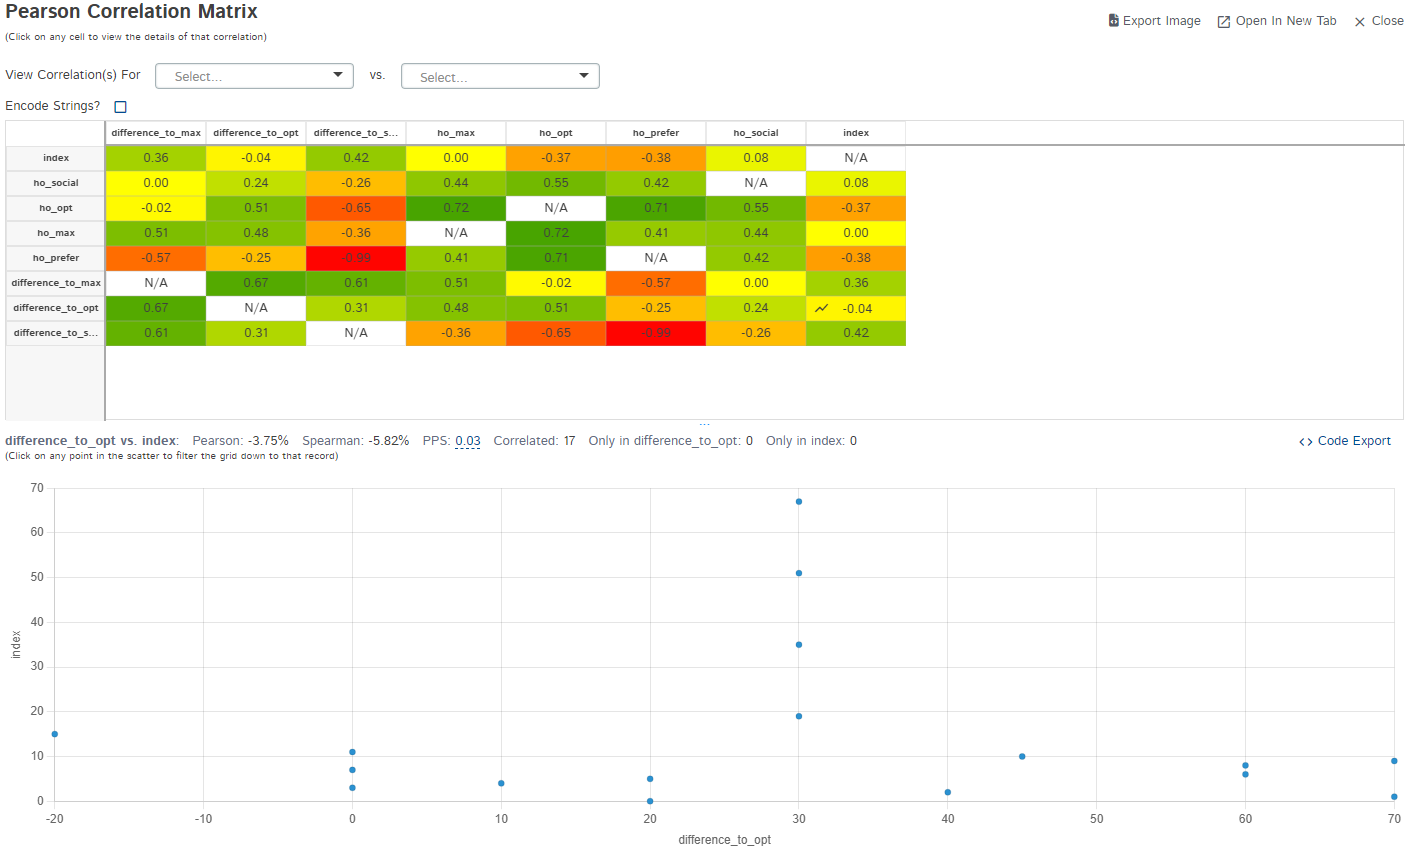

In [ ]:
dtale_app.USE_COLAB = True

dtale.show(ho_shares)

# explore for yourself, e.g. correlation; see before

# Exploring via [Seaborn](https://seaborn.pydata.org/) 

In [ ]:
sns.catplot(data=ho_shares, kind="violin", x="Activity", y="ho_prefer", hue="ho_max")

In [ ]:
sns.jointplot(data=ho_shares, x="ho_social", y="ho_prefer", hue="ho_max")

In [ ]:
sns.pairplot(data=ho_shares, hue="ho_social")